In [79]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [112]:
IMAGE_FOLDERS = [
    os.path.join("D:\ML model\HAM10000_images_part_1"), 
    os.path.join( "D:\ML model\HAM10000_images_part_2"), 
    os.path.join( "D:\ML model\HAM10000_segmentations_lesion_tschandl"),
]
CSV_FILE = os.path.join("D:\ML model\HAM10000_metadata")

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Nayan Keote\AppData\Local\Temp\ipykernel_19244\1794718538.py:2: SyntaxWarning: invalid escape sequence '\M'
  os.path.join("D:\ML model\HAM10000_images_part_1"),
C:\Users\Nayan Keote\AppData\Local\Temp\ipykernel_19244\1794718538.py:3: SyntaxWarning: invalid escape sequence '\M'
  os.path.join( "D:\ML model\HAM10000_images_part_2"),
C:\Users\Nayan Keote\AppData\Local\Temp\ipykernel_19244\1794718538.py:4: SyntaxWarning: invalid escape sequence '\M'
  os.path.join( "D:\ML model\HAM10000_segmentations_lesion_tschandl"),
C:\Users\Nayan Keote\AppData\Local\Temp\ipykernel_19244\1794718538.py

In [105]:
IMAGE_FOLDERS

['D:\\ML model\\HAM10000_images_part_1',
 'D:\\ML model\\HAM10000_images_part_2',
 'D:\\ML model\\HAM10000_segmentations_lesion_tschandl',
 'D:\\ML model\\ISIC2018_Task3_Test_Images\\ISIC2018_Task3_Test_Images']

In [113]:
# 2️⃣ Load Labels
df = pd.read_csv(CSV_FILE)
df = df[["image_id", "dx"]]


In [114]:
benign_classes = ["bkl", "df", "nv", "vasc"]
df["label"] = df["dx"].apply(lambda x: 0 if x in benign_classes else 1)

In [115]:
image_size = (128, 128)  # Resize images
X, y = [], []

In [116]:
for folder in IMAGE_FOLDERS:
    print(f"📂 Processing folder {folder}...")
    if not os.path.exists(folder):  
        print(f"⚠️ Warning: Folder {folder} not found. Skipping...")
        continue  # Skip missing folders

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_id = os.path.splitext(filename)[0]  # Remove extension
            if img_id in df["image_id"].values:  # Match CSV
                try:
                    label = df[df["image_id"] == img_id]["label"].values[0]
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img) / 255.0  # Normalize
                    X.append(img_array)
                    y.append(label)
                except Exception as e:
                    print(f"❌ Error loading {img_path}: {e}")

📂 Processing folder D:\ML model\HAM10000_images_part_1...
📂 Processing folder D:\ML model\HAM10000_images_part_2...
📂 Processing folder D:\ML model\HAM10000_segmentations_lesion_tschandl...


In [117]:
X = np.array(X)
y = np.array(y)
print(f"✅ Total images loaded: {len(X)}")
print(f"✅ Total labels loaded: {len(y)}")

✅ Total images loaded: 10015
✅ Total labels loaded: 10015


In [118]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5️⃣ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [119]:
# 4️⃣ Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [120]:
# 6️⃣ Load Pre-Trained MobileNetV2 Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze pre-trained layers

# 7️⃣ Add Custom Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [121]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=(X_val, y_val), 
                    epochs=30)

c:\Users\Nayan Keote\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 63s 233ms/step - accuracy: 0.7986 - loss: 0.4969 - val_accuracy: 0.8283 - val_loss: 0.3730
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.8195 - loss: 0.3736 - val_accuracy: 0.8223 - val_loss: 0.3691
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 222ms/step - accuracy: 0.8280 - loss: 0.3683 - val_accuracy: 0.8367 - val_loss: 0.3543
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 226ms/step - accuracy: 0.8332 - loss: 0.3587 - val_accuracy: 0.8288 - val_loss: 0.3836
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.8338 - loss: 0.3636 - val_accuracy: 0.8372 - val_loss: 0.3511
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.8368 - loss: 0.3486 - val_accuracy: 0.8362 - val_loss: 0.3552
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.8373 - loss: 0.3507 - val_accuracy: 0.8422 - val_loss: 0.3502
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.8465 - loss: 0

In [123]:
# 9️⃣ Save Model
model.save(os.path.join("skin_cancer_mobilenetv2.h5"))

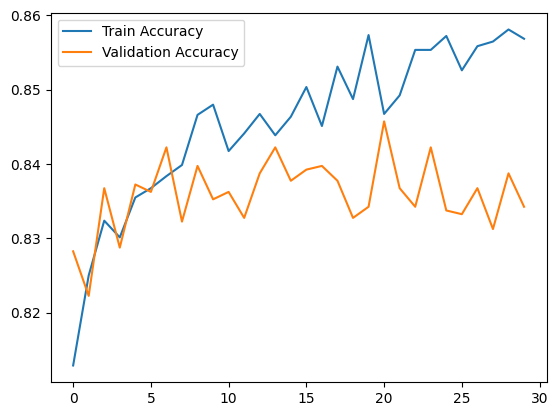

In [124]:
# 🔟 Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

C:\Users\Nayan Keote\AppData\Local\Temp\ipykernel_1908\2975219526.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"].fillna(df["age"].median(), inplace=True)


📂 Processing folder D:\ML model\HAM10000_images_part_1...
📂 Processing folder D:\ML model\HAM10000_images_part_2...
✅ Total images loaded: 10015
✅ Total metadata entries loaded: 10015


C:\Users\Nayan Keote\AppData\Local\Temp\ipykernel_1908\2975219526.py:95: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.7501 - loss: 0.5899 - val_accuracy: 0.8198 - val_loss: 0.4240 - learning_rate: 1.0000e-04
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.8121 - loss: 0.4367 - val_accuracy: 0.8278 - val_loss: 0.4048 - learning_rate: 1.0000e-04
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.8236 - loss: 0.4069 - val_accuracy: 0.8273 - val_loss: 0.3911 - learning_rate: 1.0000e-04
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.8335 - loss: 0.3816 - val_accuracy: 0.8333 - val_loss: 0.3848 - learning_rate: 1.0000e-04
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.8399 - loss: 0.3702 - val_accuracy: 0.8347 - val_loss: 0.3783 - learning_rate: 1.0000e-04
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.8318 - loss: 0.3669 - val_accuracy: 0.8372 - val_loss: 0.3727 - learning_rate: 1.0000e-04
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/s

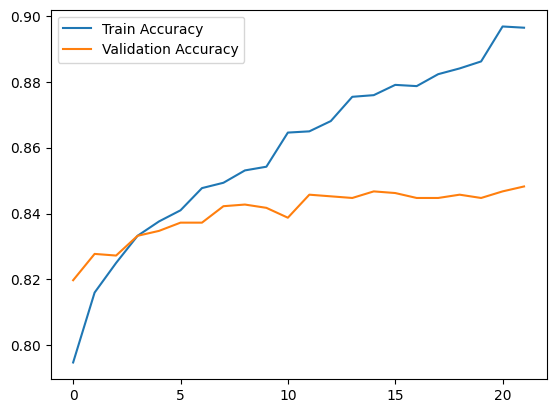

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 📂 **Dataset Paths**
IMAGE_FOLDERS = [
    "D:\ML model\HAM10000_images_part_1",
    "D:\ML model\HAM10000_images_part_2",
    "D:\ML model\HAM10000_segmentations_lesion_tschandl"
]
CSV_FILE = "D:\ML model\HAM10000_metadata"

# 📌 **Load Labels**
df = pd.read_csv(CSV_FILE)
benign_classes = ["bkl", "df", "nv", "vasc"]
df["label"] = df["dx"].apply(lambda x: 0 if x in benign_classes else 1)

# 🔄 **Preprocess Age, Sex, and Localization**
df["age"].fillna(df["age"].median(), inplace=True)
df["sex"] = df["sex"].map({"male": 0, "female": 1})
df["localization"] = df["localization"].astype("category").cat.codes  # Convert categorical to numeric

# 📌 **Preprocess Images & Metadata**
image_size = (128, 128)
X_images, X_age, X_sex, X_loc, y = [], [], [], [], []

for folder in IMAGE_FOLDERS:
    print(f"📂 Processing folder {folder}...")
    if not os.path.exists(folder):
        print(f"⚠️ Warning: Folder {folder} not found. Skipping...")
        continue

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_id = os.path.splitext(filename)[0]  # Remove extension
            if img_id in df["image_id"].values:
                try:
                    row = df[df["image_id"] == img_id].iloc[0]
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img) / 255.0  # Normalize

                    X_images.append(img_array)
                    X_age.append(row["age"])
                    X_sex.append(row["sex"])
                    X_loc.append(row["localization"])
                    y.append(row["label"])

                except Exception as e:
                    print(f"❌ Error loading {img_path}: {e}")

# 📌 **Convert to NumPy Arrays**
X_images = np.array(X_images)
X_age = np.array(X_age).reshape(-1, 1)  # Keep shape (N,1)
X_sex = np.array(X_sex).reshape(-1, 1)  
X_loc = np.array(X_loc).reshape(-1, 1)
y = np.array(y)

print(f"✅ Total images loaded: {len(X_images)}")
print(f"✅ Total metadata entries loaded: {len(X_age)}")

# 📌 **Train-Test Split**
(X_train_images, X_val_images, 
 X_train_age, X_val_age, 
 X_train_sex, X_val_sex, 
 X_train_loc, X_val_loc, 
 y_train, y_val) = train_test_split(
    X_images, X_age, X_sex, X_loc, y, test_size=0.2, random_state=42, stratify=y
)

# 📌 **Create TensorFlow Dataset**
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_train_images, X_train_age, X_train_sex, X_train_loc), y_train)
).shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_val_images, X_val_age, X_val_sex, X_val_loc), y_val)
).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# 🔥 **Build Multi-Input Model**
image_input = Input(shape=(128, 128, 3), name="image_input")
age_input = Input(shape=(1,), name="age_input")
sex_input = Input(shape=(1,), name="sex_input")
loc_input = Input(shape=(1,), name="loc_input")

# 📌 **Feature Extraction using MobileNetV2**
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)
base_model.trainable = False  # Freeze pre-trained layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# 📌 **Concatenate Image & Metadata Features**
metadata = Concatenate()([age_input, sex_input, loc_input])
metadata_dense = Dense(16, activation='relu')(metadata)

merged = Concatenate()([x, metadata_dense])
output_layer = Dense(1, activation='sigmoid')(merged)  # Binary classification

# ✅ **Compile Model**
model = Model(inputs=[image_input, age_input, sex_input, loc_input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001),  
              loss="binary_crossentropy", 
              metrics=["accuracy"])

# 🚀 **Define Callbacks**
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# 🚀 **Train Model**
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping]
)

# 💾 **Save Model**
MODEL_PATH = r"D:/ML model/skin_cancer_mobilenetv2_optimized.h5"
model.save(MODEL_PATH)

# 📈 **Plot Training History**
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
